# Contents

mtSet: set tests for association analysis
* [How to use mtSet from command line](mtSet_scripts.ipynb)
    * [Preprocessing](mtSet_preprocess.ipynb)
    * [Phenotype Simulator](mtSet_phenosim.ipynb)
    * [Running mtSet](mtSet_analyze.ipynb)
    * [Postprocessing](mtSet_postprocess.ipynb)
    * [Example for command line usage](example_usage.ipynb)
* [How to use mtSet within python](mtSet_python.ipynb)

iSet: set tests for genetic interactions with context (beta)
* [Analysis of complete designs](iSet_python_compl.ipynb)
* [Analysis of stratified designs](iSet_python_strat.ipynb)

## iSet for analysis of stratified designs (python)

iSet is an extension of mtSet that allows to test for polygenic interactions with environment or other contexts.
iSet can be applied in designs where all individuals have been phenotyped in each context (complete design) as well as for populations that have been stratified by a context variable (stratified design).
We will here see application of mtSet for analysis of stratified designs, please look [here](iSet_python_strat.ipynb) for analysis of complete designs.

A command line implementatin of iSet will be available soon.

## Setting up

In [1]:
# activiate inline plotting
%matplotlib inline

from setup import get_1000G_mtSet
import scipy as sp
import scipy.linalg
import limix
from limix.mtSet.iset import fit_iSet
import pandas as pd

In [2]:
# loading 1000G genotypes for mtSet demo
get_1000G_mtSet()

File ./../data/1000g/chrom22_subsample20_maf0.10.bed exsits
File ./../data/1000g/chrom22_subsample20_maf0.10.bim exsits
File ./../data/1000g/chrom22_subsample20_maf0.10.fam exsits
File ./../data/1000g/pheno.phe exsits
File ./../data/1000g/chrom22.cov exsits


In [3]:
# base name for bed, bim and fam
bfile = './../data/1000g/chrom22_subsample20_maf0.10'

## Split genotypes into regions

In [4]:
from limix.mtSet.core import plink_reader

In [5]:
# import genotype positions
bim = plink_reader.readBIM(bfile,usecols=(0,1,2,3))
chrom = bim[:, 0].astype(float)
pos = bim[:, -1].astype(float)

In [6]:
# uses splitter to split the genotypes
from limix.mtSet.core.splitter import Splitter
split = Splitter(pos=pos,chrom=chrom)

The method _splitGeno_ allows to define the regions that will then considered for the analysis with mtSet.
Information relative to the calculated regions can be cached in an external file by activating the cache option (see below).

| Argument        | Default       | Datatype | Explanation |
| ------------- |:-------------:|:--------:| --------|
| _method_      | 'slidingWindow' | str | Uses a sliding window approach to define regions (a region-based approach will be availabe soon) |
| _size_      | 5E+04 (50kb) | float | Window size. Pace is set at half the size of the window |
| _minSnps_      | 1 | int | Windows with number of SNPs lower that this threshold are not considered |
| _maxSnps_      | sp.inf | int | Windows with number of SNPs higher that this threshold are not considered |
| _cache_       | False | bool | If true, it activates the caching |
| _out_dir_     | './cache' | str | outdir of the cache file |
| _fname_       | None | str | Name of the file |
| _rewrite_     | False | bool | If true and the cache file already exists, the cache file is overwritten |

In [7]:
split.splitGeno(cache=True, fname='regions.h5', minSnps=4)
print '%d windows' % split.nWindows

1380 windows


## Apply mtSet

In [8]:
# import phenotype and sample relatedness
pheno_file = './../data/1000g/pheno.phe'
sample_relatedness_file = './../data/1000g/chrom22.cov'
Y = sp.loadtxt(pheno_file)[:,:1]
R = sp.loadtxt(sample_relatedness_file)

In [9]:
# let's suppose the first half of the individuals are phenotyped in context A and
# the second half on context B
Ie = sp.arange(R.shape[0])<0.5*R.shape[0]

In [10]:
# corrects for population structure using the first 10 PCs of the relatedness matrix
S_R, U_R = scipy.linalg.eigh(R+1e-4*sp.eye(R.shape[0])) # these are needed for the full mtSet model
covs = sp.concatenate([U_R[:,-10:], sp.ones([U_R.shape[0], 1])], 1)

In [11]:
# read fam
bim = plink_reader.readBIM(bfile,usecols=(0,1,2,3))
fam = plink_reader.readFAM(bfile,usecols=(0,1))

In [12]:
n_wnds = 10 # only 10 windows are considered
LLR = sp.zeros(n_wnds) # vector with test statistics of the n_wnds regions
df = pd.DataFrame()
df0 = pd.DataFrame()
import time
t0 = time.time()
for wnd_i in range(n_wnds):
    wnd_pos = split.wnd_pos[wnd_i]
    nSnps = split.nSnps[wnd_i]
    idx_wnd_start = split.idx_wnd_start[wnd_i]
    print '.. window %d - (%d, %d-%d) - %d snps' % (wnd_i, wnd_pos[0], wnd_pos[1], wnd_pos[2], nSnps)
    
    Xr = plink_reader.readBED(bfile, useMAFencoding=True, start = idx_wnd_start, nSNPs = nSnps, bim=bim , fam=fam)['snps']
    Xr-= Xr.mean(0)
    Xr/= Xr.std(0)
    Xr/= sp.sqrt(Xr.shape[1])
    
    _df, _df0 = fit_iSet(Y[:,[0]], Xr=Xr, covs=covs, n_perms=10, Ie=Ie, strat=True)
    df  = df.append(_df)
    df0 = df0.append(_df0)
print 'Elapsed:', time.time()-t0

.. window 0 - (22, 16025000-16075000) - 21 snps
fittng iSet


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/limix-0.7.9-py2.7-macosx-10.8-x86_64.egg/limix/mtSet/core/plink_reader.py:127: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  SNPs = SP.zeros(((SP.ceil(0.25*N)*4),nSNPs),order=order)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/limix-0.7.9-py2.7-macosx-10.8-x86_64.egg/limix/mtSet/core/plink_reader.py:142: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  bytes = SP.array(bytearray(f.read(nbyte))).reshape((SP.ceil(0.25*N),Sblock),order='F')


permutation 0 / 10
permutation 1 / 10
permutation 2 / 10
permutation 3 / 10
permutation 4 / 10
permutation 5 / 10
permutation 6 / 10
permutation 7 / 10
permutation 8 / 10
permutation 9 / 10
.. window 1 - (22, 16050000-16100000) - 23 snps
fittng iSet
permutation 0 / 10
permutation 1 / 10
permutation 2 / 10
permutation 3 / 10
permutation 4 / 10
permutation 5 / 10
permutation 6 / 10
permutation 7 / 10
permutation 8 / 10
permutation 9 / 10
.. window 2 - (22, 16125000-16175000) - 7 snps
fittng iSet
permutation 0 / 10
permutation 1 / 10
permutation 2 / 10
permutation 3 / 10
permutation 4 / 10
permutation 5 / 10
permutation 6 / 10
permutation 7 / 10
permutation 8 / 10
permutation 9 / 10
.. window 3 - (22, 16225000-16275000) - 9 snps
fittng iSet
permutation 0 / 10
permutation 1 / 10
permutation 2 / 10
permutation 3 / 10
permutation 4 / 10
permutation 5 / 10
permutation 6 / 10
permutation 7 / 10
permutation 8 / 10
permutation 9 / 10
.. window 4 - (22, 16250000-16300000) - 16 snps
fittng iSet
pe

The dataframe df contains log likelihood ratio scores for the different models, variance component attributable to persistent rescaling-GxC and heterogeneity-GxC and information about convergence

In [13]:
df

,mtSet LLR,iSet LLR,iSet-het LLR,Persistent Var,Rescaling-GxC Var,Heterogeneity-GxC var,Converged
0,1.253016e+00,2.536109e-01,1.431984e-01,2.688312e-02,7.333731e-03,1.188360e-02,1.0
0,1.046720e+00,1.151325e-01,9.235410e-02,2.349201e-02,3.715896e-03,1.198250e-02,1.0
0,-7.759127e-12,-4.718004e-12,-7.531753e-12,3.825602e-14,2.680160e-15,1.386438e-14,1.0
0,5.018209e-01,5.018225e-01,7.699906e-08,1.309366e-03,1.511329e-02,1.335998e-11,1.0
0,2.301945e-02,2.302026e-02,7.006946e-08,5.349272e-04,2.259426e-03,6.429398e-14,1.0
0,-1.626164e-07,-1.625445e-07,-1.626098e-07,5.070048e-13,3.452770e-13,2.296414e-14,1.0
0,3.544433e-01,3.472862e-01,-1.220924e-07,6.576249e-03,6.109514e-03,1.802756e-09,1.0
0,-6.524203e-09,-6.384383e-09,-6.511513e-09,1.032236e-12,1.208656e-12,1.005793e-14,1.0
0,2.143352e+00,1.430663e+00,5.423550e-01,2.342530e-02,3.305018e-04,2.340622e-02,1.0
0,9.827811e-01,9.496539e-01,5.507960e-02,1.201311e-02,8.315638e-03,6.524066e-03,1.0


The dataframe df0 contains log likelihood ratios when data are from the null.
These are necessary to iSet to calculate P values.

In [14]:
df0

,iSet LLR0,iSet-het LLR0,mtSet LLR0
0,5.121553e-03,2.542095e-09,-1.799094e-11
1,2.117660e-02,-8.302578e-09,3.735383e-01
2,1.437622e-01,5.130119e-12,-6.312462e-11
3,1.993492e-01,2.753211e-10,4.805032e-02
4,-1.125329e-09,4.282015e-10,-3.879563e-11
5,2.991782e+00,7.004407e-02,2.384048e-01
6,1.794582e-01,5.424704e-07,-3.859668e-11
7,1.498764e+00,-2.430056e-12,-6.259171e-10
8,1.015898e+00,9.421524e-02,-4.078515e-11
9,1.196554e-11,-2.214463e-09,-4.505125e-10


### Variance Component Plot

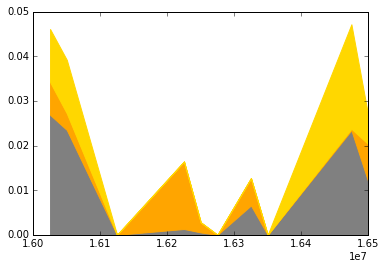

In [15]:
import pylab as pl
tot_var = df['Persistent Var'].values + df['Rescaling-GxC Var'].values + df['Heterogeneity-GxC var'].values
nohet_var = df['Persistent Var'].values + df['Rescaling-GxC Var'].values
pl.fill_between(split.wnd_pos[:n_wnds,1], 0, df['Persistent Var'].values, color='gray')
pl.fill_between(split.wnd_pos[:n_wnds,1], df['Persistent Var'].values, nohet_var, color='Orange')
pl.fill_between(split.wnd_pos[:n_wnds,1], nohet_var, tot_var, color='Gold')

### P-values

Emprical P values are obtained from a relatively small number of genome-wide permutations by pooling across all conisdered steps.

In [16]:
from limix.mtSet.core.iset_utils import calc_emp_pv_eff
#calculate P values for the three tests
for test in ['mtSet', 'iSet', 'iSet-het']:
    df[test+' pv'] = calc_emp_pv_eff(df[test+' LLR'].values, df0[test+' LLR0'].values)

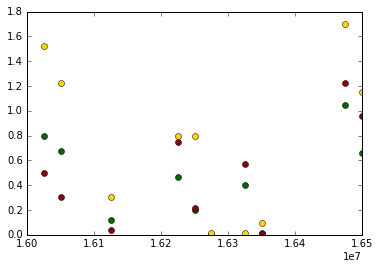

In [17]:
#makes a manhattan plot
wnd_start = split.wnd_pos[:n_wnds,1]
wnd_end = split.wnd_pos[:n_wnds,2]
import pylab as pl
pl.plot(wnd_start, -sp.log10(df['mtSet pv'].values), 'o', color='DarkGreen')
pl.plot(wnd_start, -sp.log10(df['iSet pv'].values), 'o', color='DarkRed')
pl.plot(wnd_start, -sp.log10(df['iSet-het pv'].values), 'o', color='Gold')